<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-processing." data-toc-modified-id="Data-processing.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data processing.</a></span></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span></li><li><span><a href="#Work-day-analisys:-IN_time,-OUT_time-and-workday-duration." data-toc-modified-id="Work-day-analisys:-IN_time,-OUT_time-and-workday-duration.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Work day analisys: IN_time, OUT_time and workday duration.</a></span></li><li><span><a href="#Final-report" data-toc-modified-id="Final-report-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Final report</a></span></li></ul></div>

# Find Revit top users (package licenses)

### Dependancies.

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import math

from scipy.spatial.distance import pdist, squareform

from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import missingno as msno
import hashlib
import itertools
import os
import re

### Data processing.

In [3]:
folder_path = r"./data"

Now we will read all log files and extracts only the key lines about license events (such as `IN, OUT, DENIED, TIMESTAMP`, and `IBM PC`) for further analysis. It then organizes these lines into blocks by session (grouped by timestamp or PC marker), attaches the session timestamp to each line for context, and prepares the data for clean parsing in the next steps. This preprocessing is necessary because the raw log files are unstructured, and we need a reliable way to segment and timestamp each relevant event for accurate usage analysis.

In [ ]:
info_list = []

files = os.listdir(folder_path)
for file_name in files:
    if file_name.endswith(".log"): # Change this to match the extension of your files
        file_path = os.path.join(folder_path, file_name)
        # Try opening the file with 'latin-1' encoding
        with open(file_path, "r", encoding="latin-1") as file:
            for line in file:
                if line.find('TIMESTAMP') != -1 or line.find('IN:') != -1 or line.find('OUT:') != -1 or line.find('DENIED:') != -1 or line.find('IBM PC') != -1:
                    info_list.append(line) # Unite all important lines in one schedule
# info_list[-50:]

In [5]:
temp_list = []
result = []
for item in info_list:
    if 'TIMESTAMP' in item or 'IBM PC' in item:
        if temp_list:
            result.append(temp_list)
            temp_list = []
    if temp_list or 'TIMESTAMP' or 'IBM PC' in item:
        temp_list.append(item)
if temp_list:
    result.append(temp_list)

# result[20]

In [6]:
new_data = []
for item_list in result:
    if 'TIMESTAMP' in item_list[0]:
        date = item_list[0].split('TIMESTAMP')[-1]
    elif '(IBM PC)' in item_list[0]:
        date = item_list[0].split('(IBM PC)')[-1]
    new_result = []
    for line in item_list:
        new_line = line.replace(line, date +' '+ line)
        new_result.append(new_line)
    del new_result[0]
    if new_result != []:
        new_data.append(new_result)

len(new_data)

1501

Following block flattens the cleaned session data and removes lines related to package licenses and AutoCAD, focusing only on relevant Revit license events. The resulting list is converted into a DataFrame. After checking for key separators, the code then parses out structured information—such as timestamp, status, license type, user name, and additional fields—by splitting and cleaning each log line. This prepares the raw text for accurate, column-based analysis in pandas.

In [7]:
data_for_df = itertools.chain.from_iterable(new_data)

In [8]:
data_for_df_clean = []
for line in data_for_df:
    if '_T_F' not in line:
        if 'SERVER-OUT' not in line:
            data_for_df_clean.append(line)

In [9]:
data = pd.DataFrame(data_for_df_clean)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152030 entries, 0 to 152029
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       152030 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [10]:
# Checking DF for separators.
print(data[0].str.contains('(adskflex)').unique())
print(data[0].str.contains('"').unique())
print(data[0].str.contains('@').unique())

[ True]
[ True]
[ True]


In [11]:
data['date_time'] = data[0].str.split('(adskflex)').str[0]
data['temp'] = data[0].str.split('(adskflex)').str[2]
data['status'] = data['temp'].str.split('"').str[0]
data['license'] = data['temp'].str.split('"').str[1]
data['temp_1'] = data['temp'].str.split('"').str[2]
data['name'] = data['temp_1'].str.split('@').str[0]
data['temp_2'] = data['temp_1'].str.split('@').str[1]
data['location'] = data['temp_2'].str.split(' ').str[0]
data['additional'] = data['temp_2'].str.split(' ').str[2]
data['status'] = data['status'].str.split(' ').str[1]
data['status'] = data['status'].str.split(':').str[0]
data['date_time'] = data['date_time'].str.replace('(', '')
data['date_time'] = data['date_time'].str.replace(')', '')
data['license'] = data['license'].str.split('_').str[-2]

data = data.drop(columns=[0, 'temp', 'temp_1', 'temp_2'])

data['date_time'] = data['date_time'].replace('\n ', 'T', regex=True)

This block finishes cleaning and enriching the dataset. It standardizes the `'additional'` column by removing spaces and replacing status phrases with simplified labels. The `'date_time'` strings are cleaned of extra spaces, then converted to pandas datetime objects for accurate time analysis. Several new columns are added to capture useful time features—such as day of the week, day, month, and date—for grouping and plotting. Both `'status'` and `'name'` fields are converted to lowercase and stripped of whitespace for consistency. Any empty or whitespace-only fields are set to `NaN`. Finally, the code extracts the time and hour from each event’s timestamp for detailed usage patterns, and checks the dataframe structure.

In [12]:
data['additional'] = data['additional'].str.strip()
data['additional'] = data['additional'].str.replace(re.escape('(INACTIVE)'), 'inactive')
data['additional'] = data['additional'].str.replace(re.escape('(Licensed'), 'licensed number reached')

In [13]:
data['date_time'].head()

0     5/23/2023T 7:46:09 
1     5/23/2023T 7:46:26 
2     5/23/2023T 7:47:27 
3     5/23/2023T 7:47:40 
4     5/23/2023T 7:47:58 
Name: date_time, dtype: object

In [14]:
data['date_time'] = data['date_time'].str.replace(r'\s+', '', regex=True)
# data.iloc[100:120]

In [15]:
data.date_time = pd.to_datetime(data.date_time, format='%m/%d/%YT%H:%M:%S')
# data

In [16]:
data['day_of_week'] = data['date_time'].dt.strftime('%a')
data['day'] = data['date_time'].dt.strftime('%d')
data['month'] = data['date_time'].dt.strftime('%b')
data['date'] = data['date_time'].dt.date

data['status'] = data['status'].str.lower()
data['name'] = data['name'].str.lower()

data['status'] = data['status'].str.strip()
data['additional'] = data['additional'].str.strip()

data = data.replace(r'^\s*$', np.nan, regex=True)

In [17]:
data['time'] = data['date_time'].dt.time
data['hours'] = data['date_time'].dt.hour

In [18]:
data.reset_index(drop=True).head(0)

,date_time,status,license,name,location,additional,day_of_week,day,month,date,time,hours


In [19]:
data['date_time']

0        2023-05-23 07:46:09
1        2023-05-23 07:46:26
2        2023-05-23 07:47:27
3        2023-05-23 07:47:40
4        2023-05-23 07:47:58
                 ...        
152025   2024-02-29 14:40:46
152026   2024-02-29 14:41:52
152027   2024-02-29 14:42:09
152028   2024-02-29 14:42:11
152029   2024-02-29 14:42:11
Name: date_time, Length: 152030, dtype: datetime64[ns]

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152030 entries, 0 to 152029
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date_time    152030 non-null  datetime64[ns]
 1   status       152030 non-null  object        
 2   license      152030 non-null  object        
 3   name         152030 non-null  object        
 4   location     152030 non-null  object        
 5   additional   69843 non-null   object        
 6   day_of_week  152030 non-null  object        
 7   day          152030 non-null  object        
 8   month        152030 non-null  object        
 9   date         152030 non-null  object        
 10  time         152030 non-null  object        
 11  hours        152030 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(10)
memory usage: 13.3+ MB


This part anonymizes user data to protect privacy. It first collects all unique user names, then generates a unique, short hash-based ID for each name using MD5 (taking the first 8 characters for brevity). The hash IDs are merged back into the main dataframe, replacing the real user names with anonymized identifiers. The original `'name'` column is then dropped. This ensures that all analysis and visualizations can be shared or published without exposing sensitive user information.

In [21]:
name_id = data['name'].unique()
name_id = pd.DataFrame(name_id)
name_id[0].unique()
name_id['id'] = name_id[0].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest()[:8])
name_id.columns = ['name', 'id']

data = pd.merge(data, name_id, on='name')
data = data.drop(columns=['name'])

data.head(20)

,date_time,status,license,location,additional,day_of_week,day,month,date,time,hours,id
0,2023-05-23 07:46:09,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:46:09,7,66444989
1,2023-05-23 07:46:26,out,2021,DG99M63,NaN,Tue,23,May,2023-05-23,07:46:26,7,e6912c00
2,2023-05-23 07:47:27,out,2021,74TT2T3,NaN,Tue,23,May,2023-05-23,07:47:27,7,34beb027
3,2023-05-23 07:47:40,in,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:47:40,7,66444989
4,2023-05-23 07:47:58,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:47:58,7,66444989
5,2023-05-23 07:49:32,in,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:49:32,7,66444989
6,2023-05-23 07:51:46,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:51:46,7,66444989
7,2023-05-23 07:58:58,out,2021,1T39M63,NaN,Tue,23,May,2023-05-23,07:58:58,7,f1ad8b33
8,2023-05-23 08:05:10,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:05:10,8,941ffeb6
9,2023-05-23 08:05:29,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:05:29,8,941ffeb6


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152030 entries, 0 to 152029
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date_time    152030 non-null  datetime64[ns]
 1   status       152030 non-null  object        
 2   license      152030 non-null  object        
 3   location     152030 non-null  object        
 4   additional   69843 non-null   object        
 5   day_of_week  152030 non-null  object        
 6   day          152030 non-null  object        
 7   month        152030 non-null  object        
 8   date         152030 non-null  object        
 9   time         152030 non-null  object        
 10  hours        152030 non-null  int32         
 11  id           152030 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(10)
memory usage: 13.3+ MB


### Data analysis

This block focuses the dataset on key license events—specifically, when a user checks out `("out")` or is denied a license. It creates a filtered dataframe of only these events. To avoid counting duplicate actions, it drops any duplicate records for the same user, status, and date combination, ensuring each user’s daily license activity is only counted once per status. The `'date_time'` column is removed for simplicity, and the dataframe is reset and inspected for further analysis.

In [23]:
len(data['id'].unique())

221

In [24]:
data_new = data[(data['status'] == 'out') | (data['status'] == 'denied')]
data_new.reset_index(drop=True).head(20)

,date_time,status,license,location,additional,day_of_week,day,month,date,time,hours,id
0,2023-05-23 07:46:09,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:46:09,7,66444989
1,2023-05-23 07:46:26,out,2021,DG99M63,NaN,Tue,23,May,2023-05-23,07:46:26,7,e6912c00
2,2023-05-23 07:47:27,out,2021,74TT2T3,NaN,Tue,23,May,2023-05-23,07:47:27,7,34beb027
3,2023-05-23 07:47:58,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:47:58,7,66444989
4,2023-05-23 07:51:46,out,2021,5QMT1F3,NaN,Tue,23,May,2023-05-23,07:51:46,7,66444989
5,2023-05-23 07:58:58,out,2021,1T39M63,NaN,Tue,23,May,2023-05-23,07:58:58,7,f1ad8b33
6,2023-05-23 08:05:10,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:05:10,8,941ffeb6
7,2023-05-23 08:05:29,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:05:29,8,941ffeb6
8,2023-05-23 08:09:25,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:09:25,8,941ffeb6
9,2023-05-23 08:09:25,out,2021,GWK8M63,NaN,Tue,23,May,2023-05-23,08:09:25,8,941ffeb6


In [25]:
data_new1 = data_new.drop_duplicates(subset=['date', 'id','status'])
data_new1 = data_new1.drop(columns=['date_time'])
data_new1.reset_index()
data_new1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24252 entries, 0 to 152018
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   status       24252 non-null  object
 1   license      24252 non-null  object
 2   location     24252 non-null  object
 3   additional   10527 non-null  object
 4   day_of_week  24252 non-null  object
 5   day          24252 non-null  object
 6   month        24252 non-null  object
 7   date         24252 non-null  object
 8   time         24252 non-null  object
 9   hours        24252 non-null  int32 
 10  id           24252 non-null  object
dtypes: int32(1), object(10)
memory usage: 2.1+ MB


In [80]:
in_entrances = data_new1[data_new1['status'] == 'out'].pivot_table(index=['date'], values='id', aggfunc='count')

# in_entrances.plot(
#     grid=True,
#     figsize=(20, 6),
#     rot=90,
#     fontsize=10,
#     style='o-',
#     color='r',
# )

# plt.title('Unique Revit users per day', pad=20)
# plt.xlabel('Day')
# plt.ylabel('Count')
# plt.xticks(in_entrances.index, fontsize=8) 
# plt.legend(loc='upper left')
# plt.legend(['Unique users count'])
# plt.show()

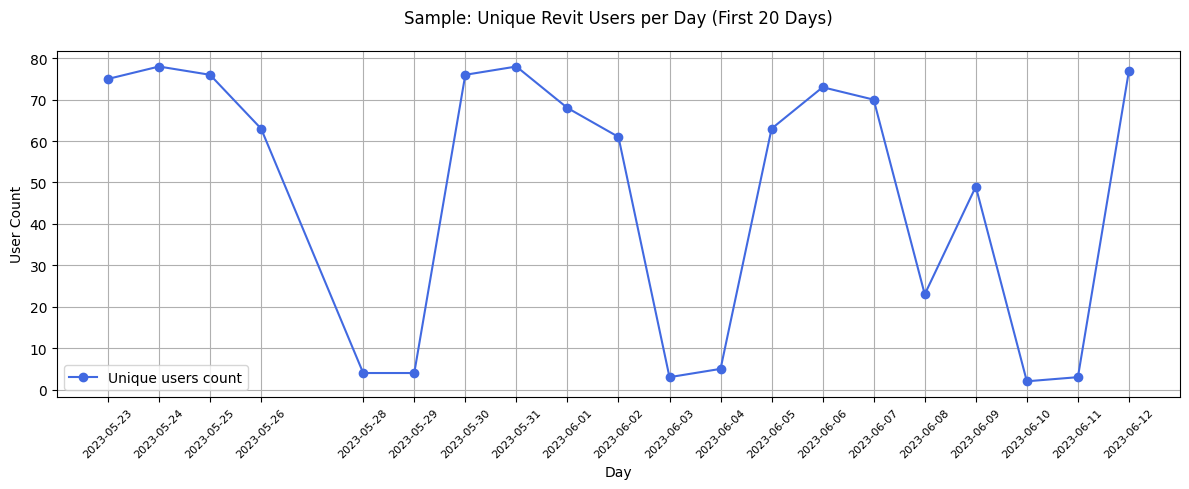

In [84]:
sample_in_entrances = in_entrances.head(20)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(sample_in_entrances.index, sample_in_entrances['id'], 'o-', color='royalblue')

ax.set_xticks(sample_in_entrances.index)
ax.set_xticklabels([str(date)[:10] for date in sample_in_entrances.index], rotation=45, fontsize=8)

plt.title('Sample: Unique Revit Users per Day (First 20 Days)', pad=20)
plt.xlabel('Day')
plt.ylabel('User Count')
plt.legend(['Unique users count'], loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

This graph visualizes the number of unique Revit users per day, based on the deduplicated `"out"` license events. Each point represents a single day, and the y-axis shows the count of distinct users who checked out a license on that day. The line and dots make it easy to see day-to-day variation and activity spikes.

In [27]:
names = []
times = []
for name, count in data_new1[data_new1['status'] == 'out'].groupby('id'):
    names.append(name)
    times.append(len(count))
#     print('{} occurs {} time(s)'.format(name, len(count)))

name_count_data = pd.DataFrame([names, times])
name_count_data = name_count_data.T
name_count_data.columns = ['id', 'count']
name_count_data['count'] = pd.to_numeric(name_count_data['count'])
print(name_count_data.info())
name_count_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      221 non-null    object
 1   count   221 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ KB
None


,id,count
0,01541ef7,44
1,049f5937,116
2,05438ec8,4
3,05f07e59,147
4,0631c7d8,1


In [86]:
# ax1 = data_new1[data_new1['status'] == 'out'].groupby('id')['id'].count().plot(
#     rot=90,
#     figsize=(15, 5),
#     y='id',
#     style='o',
#     grid=True
# );
# ax1.set_title('Frequancy license usage by person', pad = 20);
# ax1.set_xlabel('User id');
# ax1.set_ylabel('Frequancy during the observation period');
# ax1.set_xticks(range(len(data_new1['id'].unique())))  # Set x-ticks positions
# ax1.set_xticklabels(data_new1['id'].unique(), rotation=90, fontsize=5)  # Set x-tick labels
# plt.show()

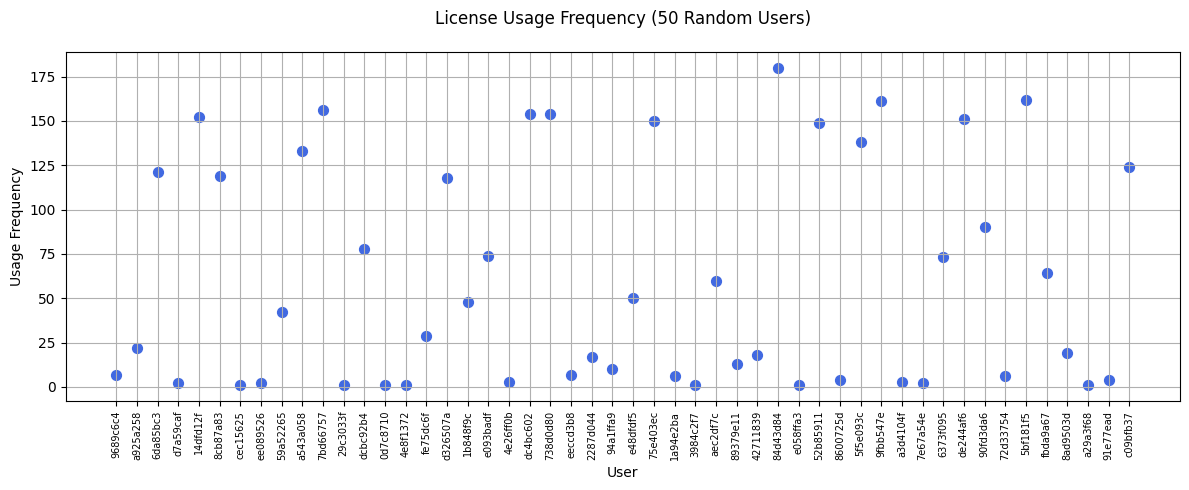

In [97]:
user_freq = data_new1[data_new1['status'] == 'out'].groupby('id')['id'].count()
sample_n = 50
sample_users = user_freq.sample(n=sample_n, random_state=42)
sample_users = sample_users.reset_index(name='usage_frequency')  # Fix column name conflict

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(sample_users.index, sample_users['usage_frequency'], color='royalblue', s=50)

ax.set_title('License Usage Frequency (50 Random Users)', pad=20)
ax.set_xlabel('User')
ax.set_ylabel('Usage Frequency')
ax.set_xticks(sample_users.index)
ax.set_xticklabels(sample_users['id'], rotation=90, fontsize=7)

plt.grid(True)
plt.tight_layout()
plt.show()


This scatter plot shows how often each individual user checked out a Revit license during the observation period. Each dot represents a unique anonymized user (by ID), and the y-axis indicates how many times they checked out a license. The x-axis shows all users in the dataset, sorted by their unique ID.

- The majority of users fall into two broad groups: frequent users (often above 100 uses) and occasional users (typically below 50).

- There are a few very active users with usage counts near the top of the range (approaching 180–200), suggesting power users or team leads.

- Many users have relatively low counts, indicating they only used Revit a few times during the period.

- This visualization helps identify both the most active users (who may require dedicated licenses) and low-frequency users (who could share licenses or need less access).

In [29]:
li_count = data_new1[data_new1['status'] == 'out'].groupby('id')['status'].count()
li_count = pd.DataFrame(li_count)
li_count.columns = ['count']
li_count[['count']].sort_values('count', ascending=False).head(10)

,count
id,
84cb2230,185
84d43d84,180
e6912c00,177
941ffeb6,171
925baff5,169
66444989,168
123bd329,167
7fc0a54e,167
34beb027,165


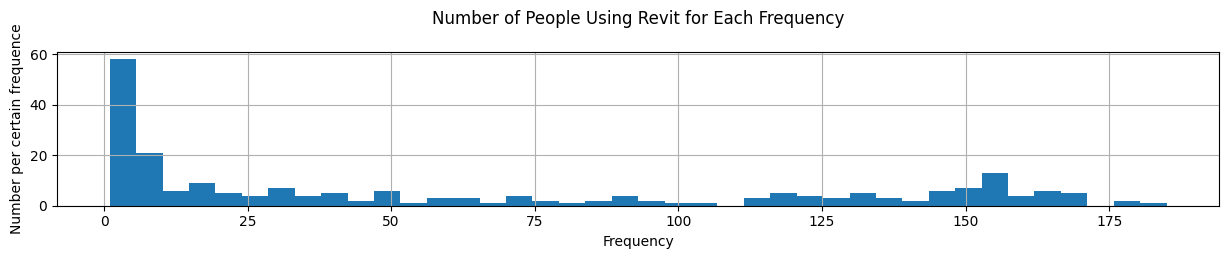

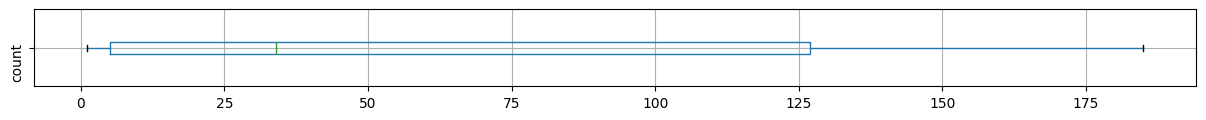

In [30]:
ax2 = name_count_data['count'].hist(
    bins=40,
    figsize=(15, 2),
);
ax2.set_title('Number of People Using Revit for Each Frequency', pad = 20);
ax2.set_xlabel('Frequency');
ax2.set_ylabel('Number per certain frequence');
plt.show()
name_count_data.boxplot(column='count' ,figsize=(15, 1), vert=False, rot = 90)
plt.show()

This histogram shows how often users checked out a Revit license during the observation period. Most users did so only a handful of times, while a smaller group checked out licenses much more frequently. The distribution is heavily skewed: a large number of users are occasional, but a few are very active. This highlights the difference between light and heavy users in organization.

In [31]:
name_count_data['count'].describe()

count    221.000000
mean      62.104072
std       62.321111
min        1.000000
25%        5.000000
50%       34.000000
75%      127.000000
max      185.000000
Name: count, dtype: float64

In [32]:
mean_days_count = name_count_data['count'].describe()['50%']
mean_days_count

np.float64(34.0)

Price of entries per month.

In [33]:
year_price = 3303
print('price of 1 entrance if you do 5 entrances a month is: {} euro'.format(3303/12/5))
print('price of 1 entrance if you do 10 entrances a month is: {} euro'.format(3303/12/10))
print('price of 1 entrance if you do 15 entrances a month is: {} euro'.format(3303/12/15))
print('price of 1 entrance if you do 20 entrances a month is: {} euro'.format(3303/12/20))

price of 1 entrance if you do 5 entrances a month is: 55.05 euro
price of 1 entrance if you do 10 entrances a month is: 27.525 euro
price of 1 entrance if you do 15 entrances a month is: 18.35 euro
price of 1 entrance if you do 20 entrances a month is: 13.7625 euro


This code calculates the effective cost per license usage (or "entrance") based on different levels of monthly activity, assuming an annual Revit license price of 3,303 euros. By dividing the yearly price over 12 months and then by the number of monthly uses (5, 10, 15, 20), it shows how the cost per use decreases as individual usage increases—helping organizations understand the value and efficiency of their license investment.

### Work day analisys: IN_time, OUT_time and workday duration.

In [34]:
# Excluding weekends
data_n = data.copy()
data_n['date_time'] = data_n['date_time'].dt.round('min')
data_n = data_n[(data_n['day_of_week'] != 'Sat') & (data_n['day_of_week'] != 'Sun')]

In [35]:
# Drop duplicates
data_n = data_n.drop_duplicates(subset=['date_time', 'id','status', 'license'])

In [36]:
# Check the dates we are working with
data_n['date'].unique()[:5]

array([datetime.date(2023, 5, 23), datetime.date(2023, 5, 24),
       datetime.date(2023, 5, 25), datetime.date(2023, 5, 26),
       datetime.date(2023, 5, 29)], dtype=object)

In [37]:
day_name = []
data_in = []
data_out = []
day_name_out = []

for date in data_n['date'].unique():
    day_name_t = []
    data_in_t = []
    data_out_t = []
    day_name_out_t = []
    day_data = data_n[data_n['date'] == date]
    for index in day_data.index:
        if day_data['status'][index] == 'out' and day_data['id'][index] not in day_name_t:
            day_name_t.append(day_data['id'][index])
            data_in_t.append(day_data['date_time'][index])
    day_name.append(day_name_t)
    data_in.append(data_in_t)
    reverse = day_data.iloc[::-1]
    reverse = reverse.reset_index()
    for index in reverse.index:
        if reverse['status'][index] == 'in' and reverse['id'][index] not in day_name_out_t:
            day_name_out_t.append(reverse['id'][index])
            data_out_t.append(reverse['date_time'][index])
    day_name_out.append(day_name_out_t)
    data_out.append(data_out_t)

print(len(data_in))
print(len(day_name))
print(len(data_out))
print(len(day_name_out))

203
203
203
203


In [38]:
df_in_list = []

for index in range(0, len(data_in)):
    df = pd.DataFrame([day_name[index], data_in[index]])
    df = df.T
    df.columns = ['id', 'time_in']
    df_in_list.append(df)

len(df_in_list)
df_in_list[15]

,id,time_in
0,90fd3da6,2023-06-13 06:51:00
1,66444989,2023-06-13 07:21:00
2,433b1ccd,2023-06-13 07:24:00
3,14dfd12f,2023-06-13 07:34:00
4,79333402,2023-06-13 08:00:00
...,...,...
78,4f5979f6,2023-06-13 14:14:00
79,ef0ee6b0,2023-06-13 14:30:00
80,391b54df,2023-06-13 16:32:00
81,0feba834,2023-06-13 21:13:00


In [39]:
df_out_list = []

for index in range(0, len(data_out)):
    df = pd.DataFrame([day_name_out[index], data_out[index]])
    df = df.T
    df.columns = ['id', 'time_out']
    df_out_list.append(df)

len(df_out_list)
df_out_list[15]

,id,time_out
0,0feba834,2023-06-13 21:13:00
1,dcbc92b4,2023-06-13 20:08:00
2,9fbb547e,2023-06-13 19:38:00
3,34beb027,2023-06-13 19:36:00
4,4d569e54,2023-06-13 19:24:00
...,...,...
77,7bd66757,2023-06-13 13:32:00
78,738d0d80,2023-06-13 12:48:00
79,a7ae9b86,2023-06-13 11:50:00
80,a7073920,2023-06-13 11:13:00


In [40]:
df_in_out_merge_list = []

for index in range(0, len(df_in_list)):
    merged_df = pd.merge(df_in_list[index], df_out_list[index], on='id')
    merged_df = merged_df.query('time_out > time_in')
    merged_df = merged_df.reset_index(drop=True)

    # Convert 'time_in' and 'time_out' to datetime objects
    merged_df['time_in'] = pd.to_datetime(merged_df['time_in'])
    merged_df['time_out'] = pd.to_datetime(merged_df['time_out'])

    merged_df['duration'] = merged_df['time_out'] - merged_df['time_in']
    merged_df['d_hours'] = merged_df['duration'] / pd.Timedelta(hours=1)
    merged_df['date'] = merged_df['time_in'].dt.date
    merged_df['in_hours'] = merged_df['time_in'].dt.time
    merged_df['out_hours'] = merged_df['time_out'].dt.time
    merged_df['month'] = merged_df['date'].apply(lambda x: x.strftime('%Y-%m'))

    df_in_out_merge_list.append(merged_df)

In [41]:
df_in_out_merge_list[5].head()

,id,time_in,time_out,duration,d_hours,date,in_hours,out_hours,month
0,b3b10783,2023-05-30 06:04:00,2023-05-30 07:22:00,0 days 01:18:00,1.300000,2023-05-30,06:04:00,07:22:00,2023-05
1,42711839,2023-05-30 07:59:00,2023-05-30 15:54:00,0 days 07:55:00,7.916667,2023-05-30,07:59:00,15:54:00,2023-05
2,c09bfb37,2023-05-30 08:09:00,2023-05-30 19:57:00,0 days 11:48:00,11.800000,2023-05-30,08:09:00,19:57:00,2023-05
3,7fc0a54e,2023-05-30 08:09:00,2023-05-30 18:19:00,0 days 10:10:00,10.166667,2023-05-30,08:09:00,18:19:00,2023-05
4,dda4ac8d,2023-05-30 08:12:00,2023-05-30 16:32:00,0 days 08:20:00,8.333333,2023-05-30,08:12:00,16:32:00,2023-05


In [42]:
count = 0
for df in df_in_out_merge_list:
    count += 1
    # if not df.empty:  # Check if the DataFrame is not empty
    #     print(df['date'].iloc[0], df['duration'].median())
# print('*****')
print('total days:',count)

total days: 203




graphs and info for day 2023-05-23


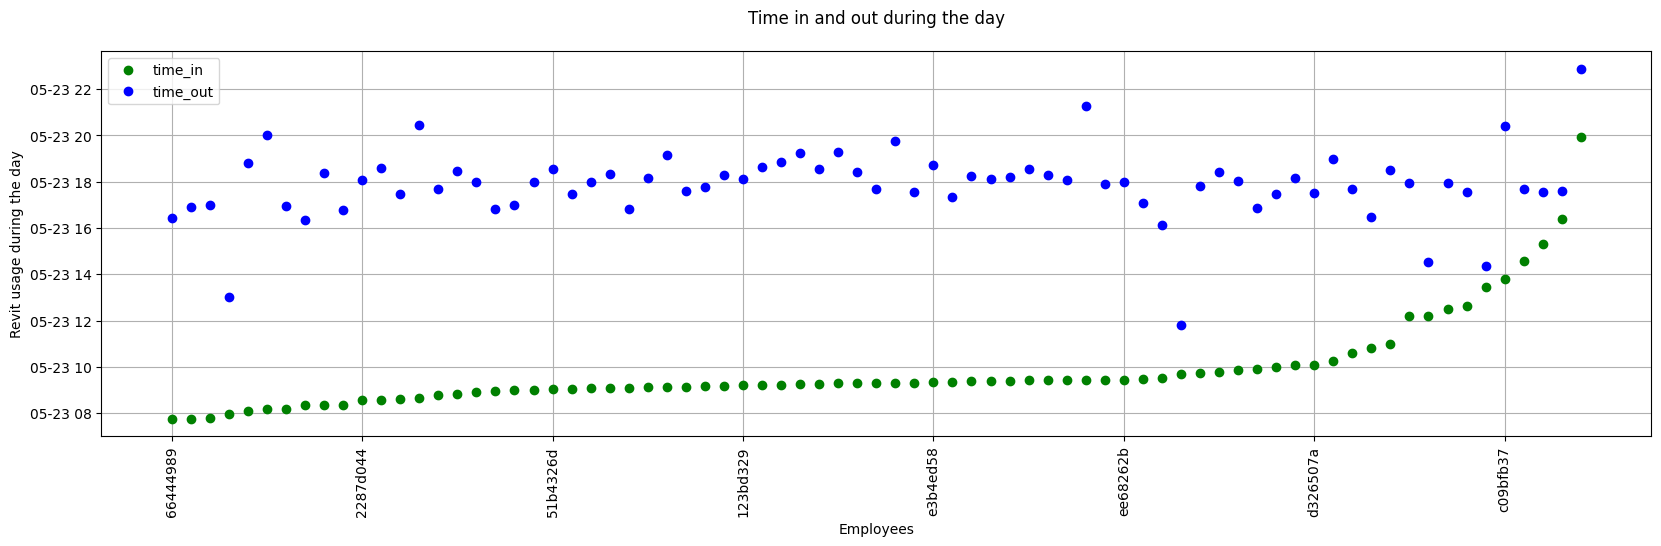

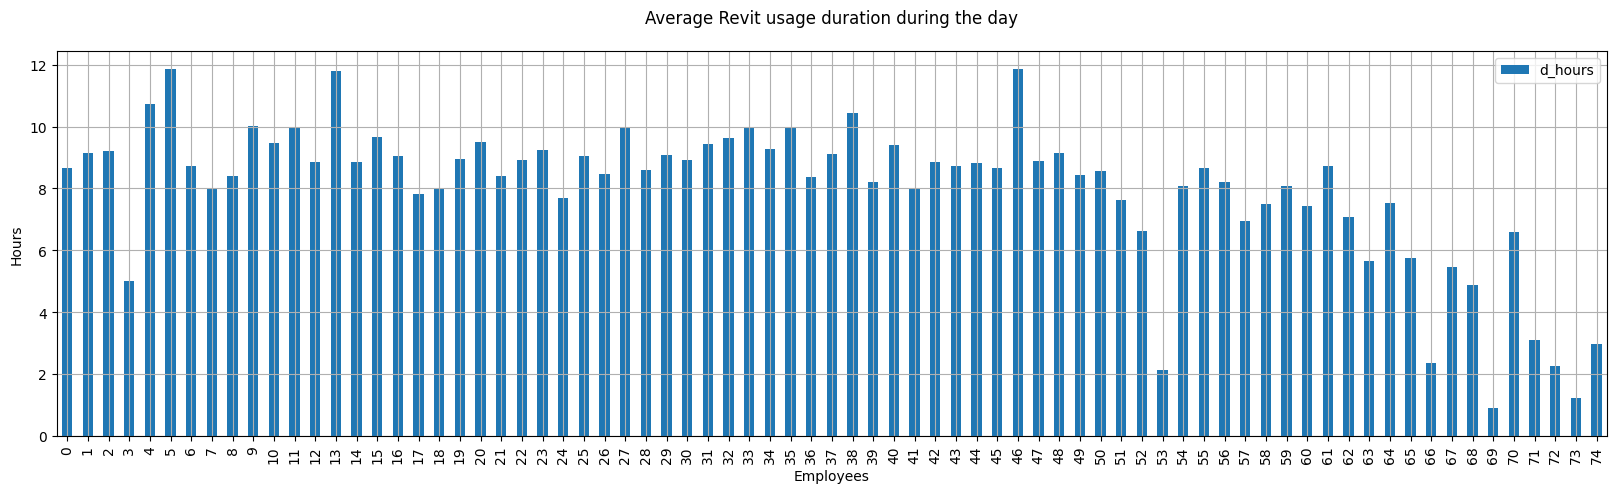


                        duration    d_hours
count                         75  75.000000
mean             0 days 07:59:44   7.995556
std    0 days 02:19:39.567814437   2.327658
min              0 days 00:54:00   0.900000
25%              0 days 07:34:30   7.575000
50%              0 days 08:39:00   8.650000
75%              0 days 09:10:30   9.175000
max              0 days 11:51:00  11.850000


graphs and info for day 2023-05-24


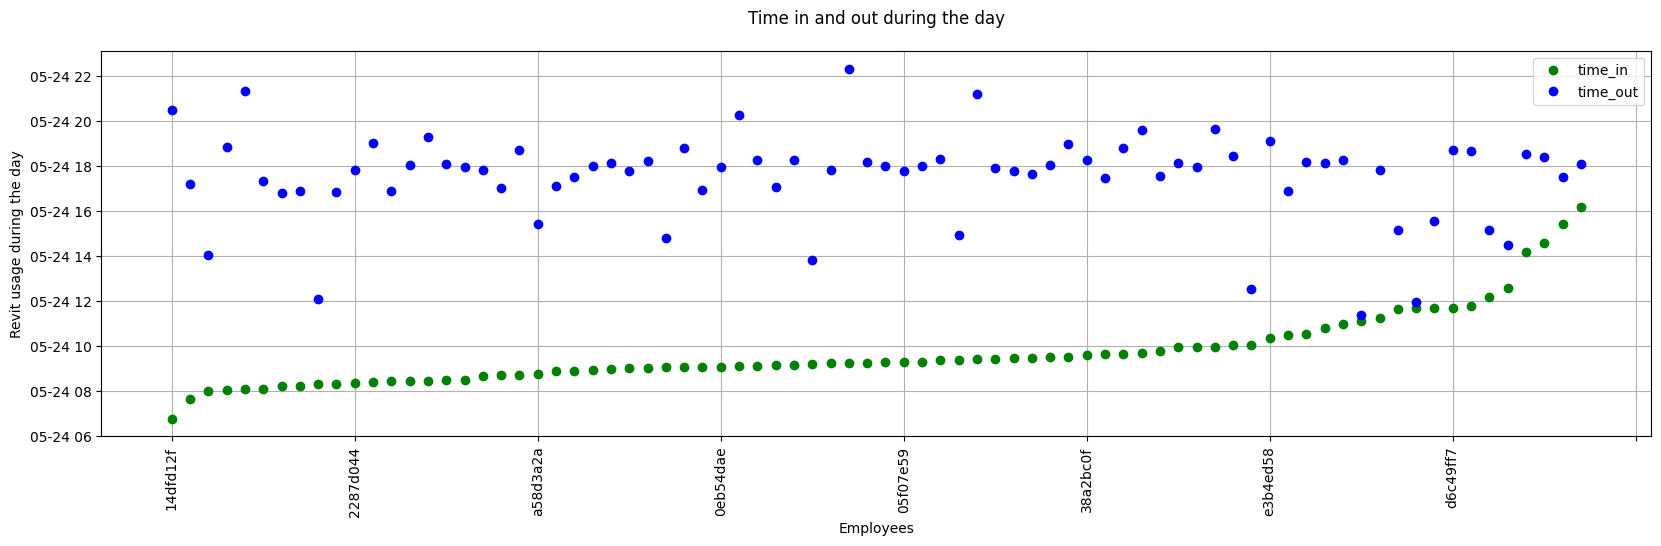

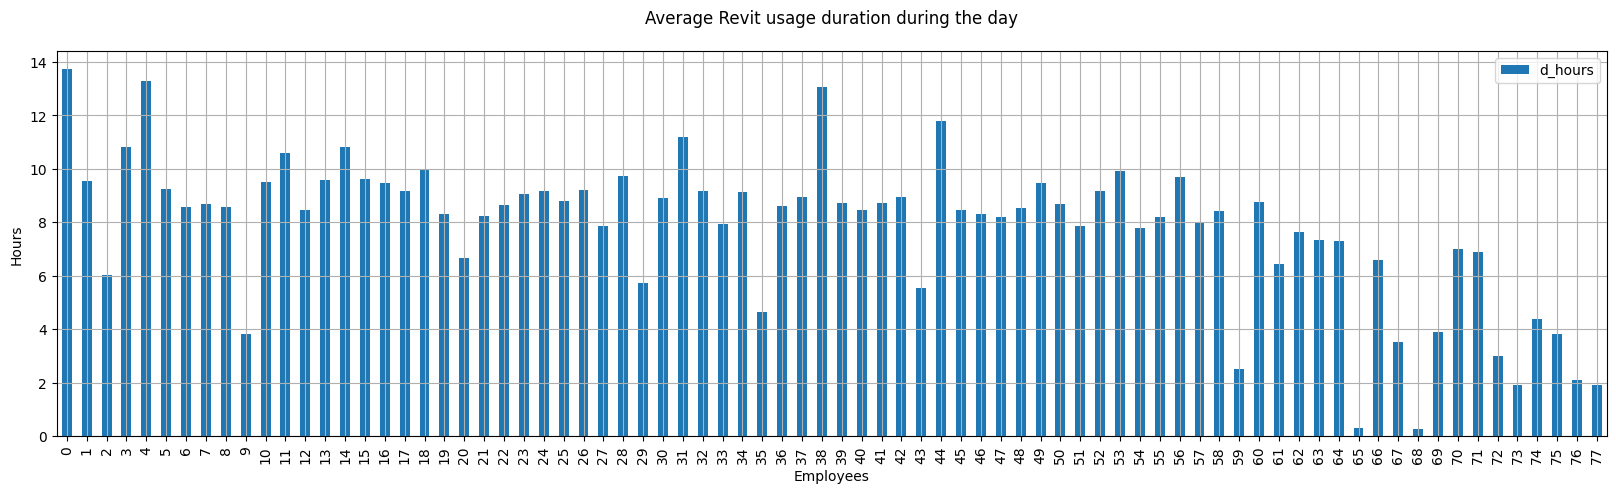


                        duration    d_hours
count                         78  78.000000
mean   0 days 07:49:34.615384615   7.826282
std    0 days 02:44:57.449585206   2.749292
min              0 days 00:16:00   0.266667
25%              0 days 06:54:45   6.912500
50%              0 days 08:33:00   8.550000
75%              0 days 09:11:30   9.191667
max              0 days 13:43:00  13.716667


graphs and info for day 2023-05-25


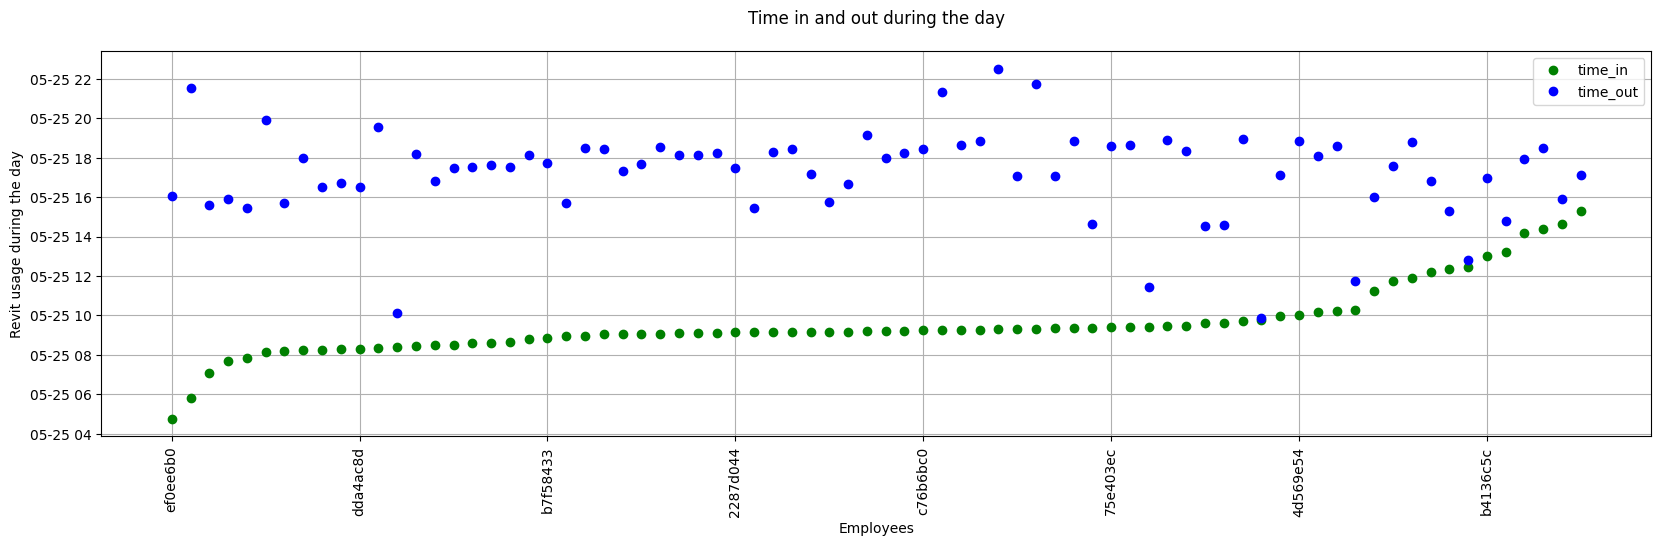

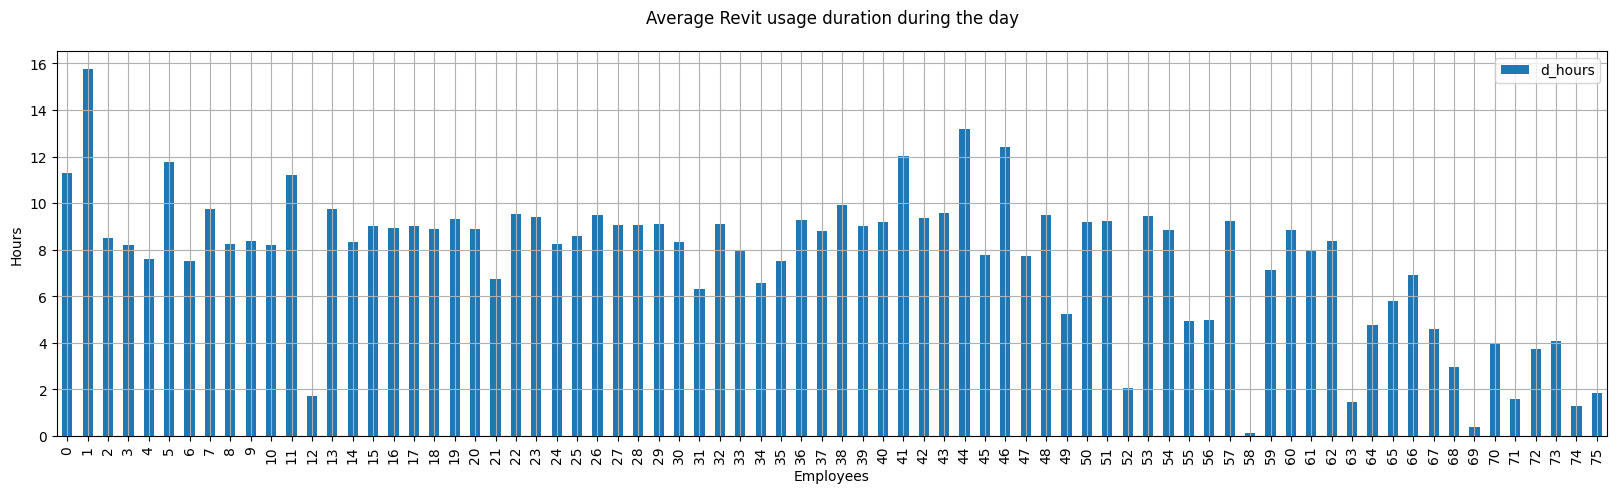


                        duration    d_hours
count                         76  76.000000
mean   0 days 07:39:26.842105263   7.657456
std    0 days 03:02:51.887253099   3.047746
min              0 days 00:07:00   0.116667
25%              0 days 06:29:15   6.487500
50%              0 days 08:27:00   8.450000
75%              0 days 09:15:30   9.258333
max              0 days 15:45:00  15.750000


In [43]:
for df in df_in_out_merge_list[:3]:
    if df['duration'].mean() > pd.Timedelta(hours=7):
        print('')
        print('')
        print('graphs and info for day {}'.format(df['date'][0]))

        df.sort_values(by='time_in').plot(
        y=['time_in', 'time_out'],
        x='id',
        style='o',
        color=['g', 'b'],
        figsize=(20, 5),
        grid=True,
        rot=90)
        plt.title('Time in and out during the day', pad = 20)
        plt.xlabel('Employees')
        plt.ylabel('Revit usage during the day')
        plt.show();

        df[['d_hours']].plot(
        kind='bar',
        grid=True,
        figsize=(20, 5));
        plt.title('Average Revit usage duration during the day', pad = 20)
        plt.xlabel('Employees')
        plt.ylabel('Hours');
        plt.show()

        print('')
        print(df.iloc[:, 3:].describe())

In [44]:
all_days_df = pd.concat(df_in_out_merge_list, ignore_index=True)
all_days_df['month'] = all_days_df['date'].apply(lambda x: x.strftime('%Y-%m'))

# Convert time_in and time_out to datetime if not already
all_days_df['time_in'] = pd.to_datetime(all_days_df['time_in'])
all_days_df['time_out'] = pd.to_datetime(all_days_df['time_out'])

# Extract hour/minute as float for average calculations
all_days_df['time_in_hour'] = all_days_df['time_in'].dt.hour + all_days_df['time_in'].dt.minute/60
all_days_df['time_out_hour'] = all_days_df['time_out'].dt.hour + all_days_df['time_out'].dt.minute/60

monthly_user_stats = all_days_df.groupby(['month', 'id']).agg({
    'time_in_hour': 'mean',
    'time_out_hour': 'mean',
    'd_hours': 'mean'
}).reset_index()


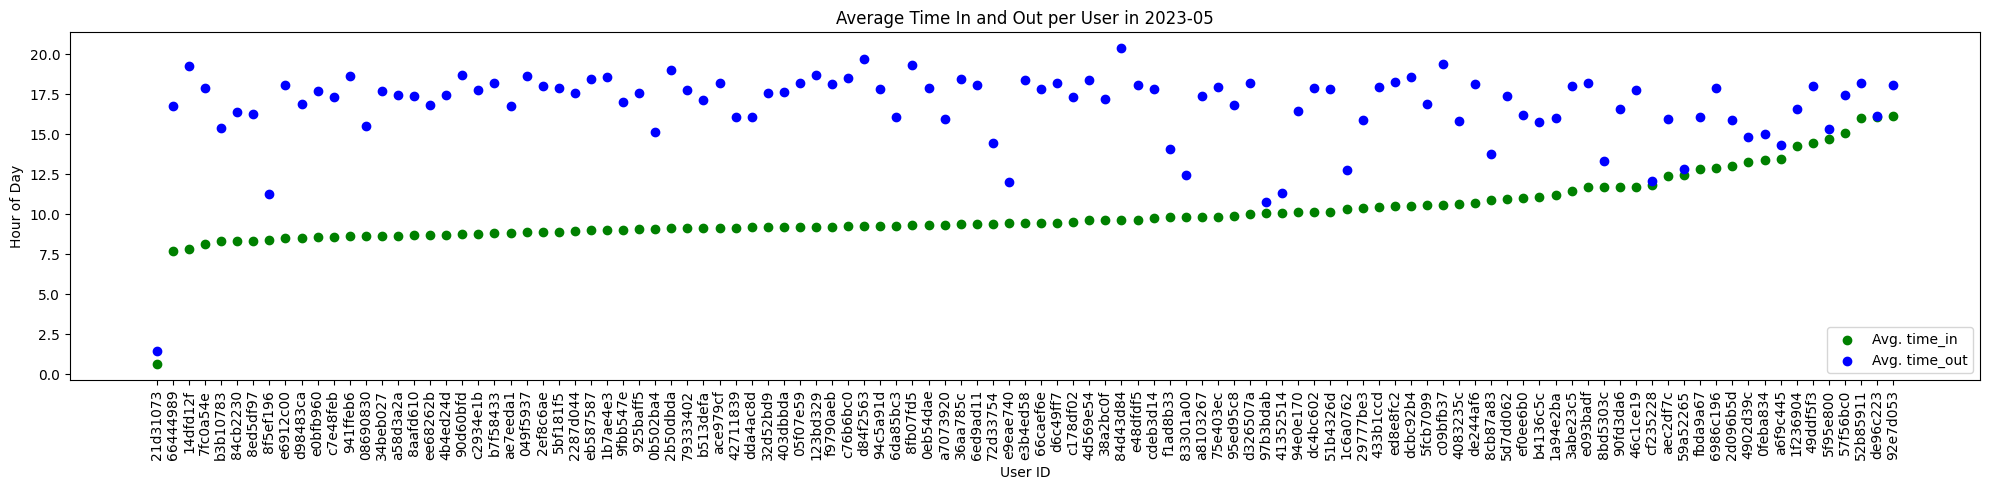

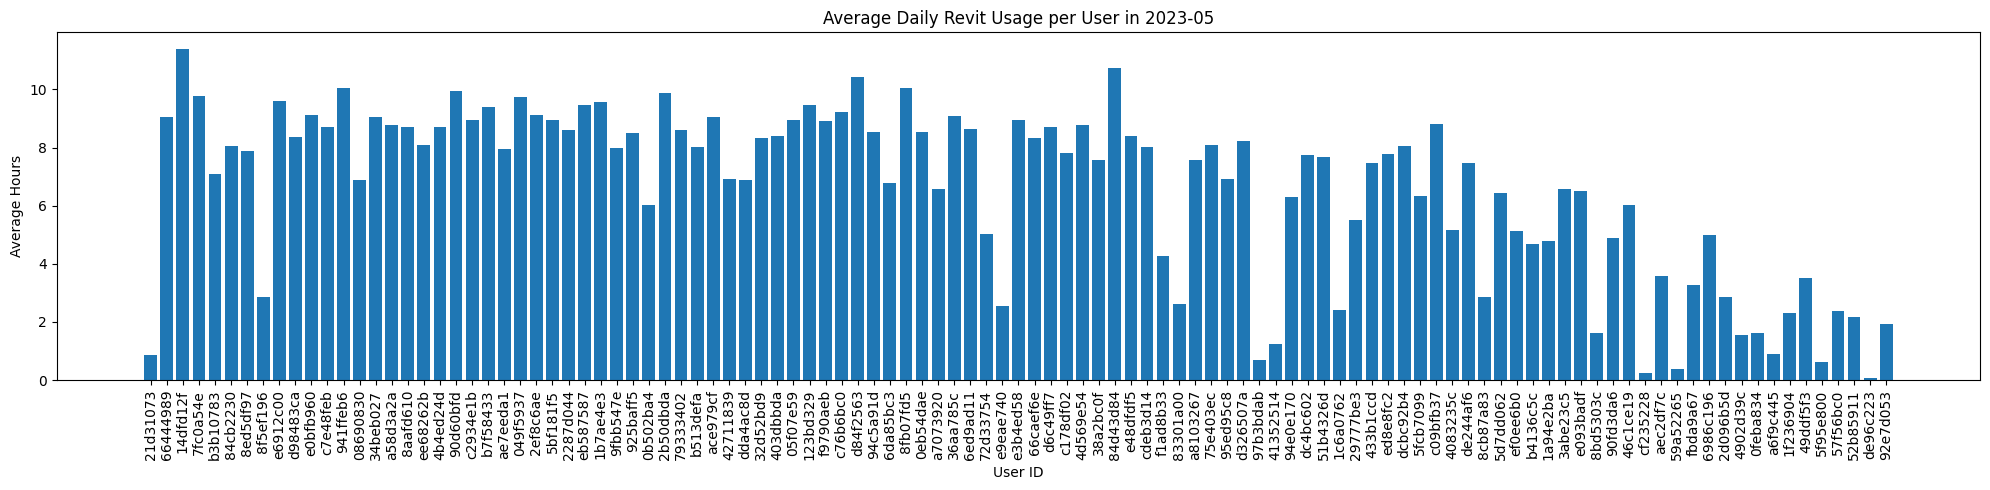

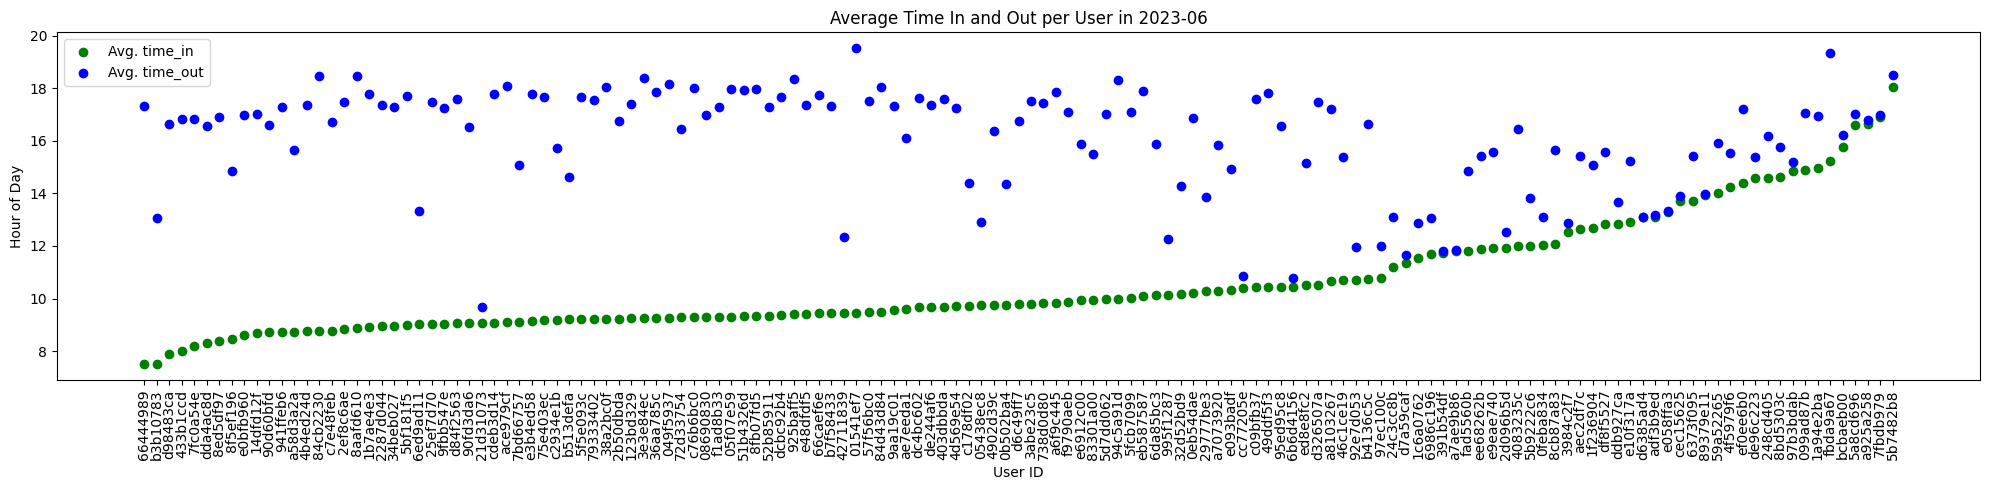

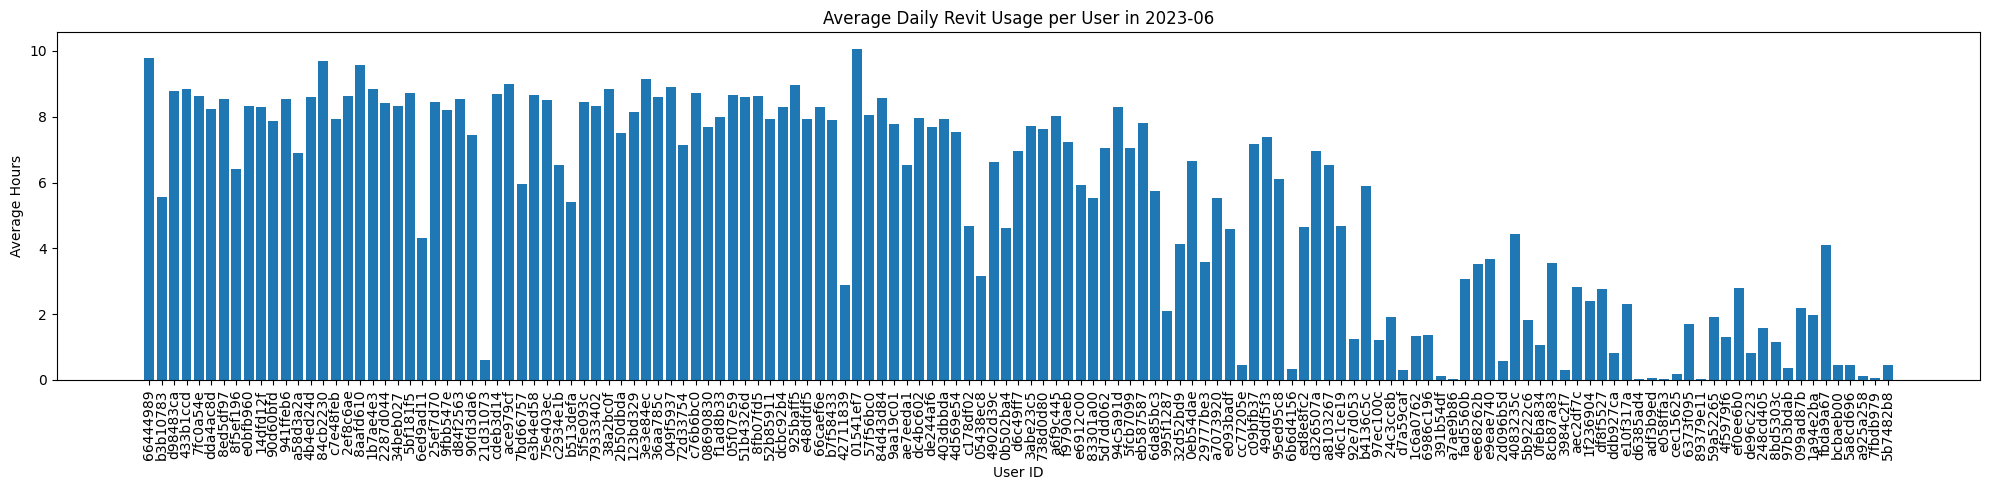

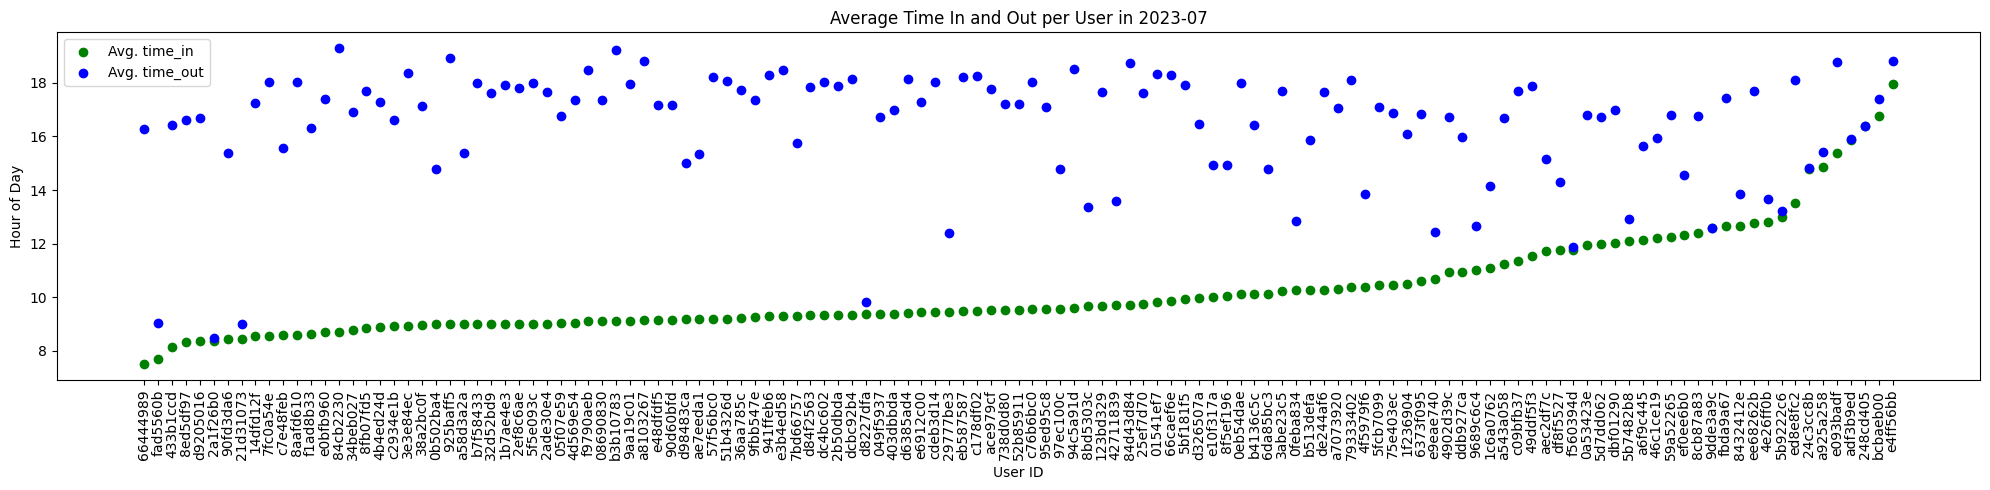

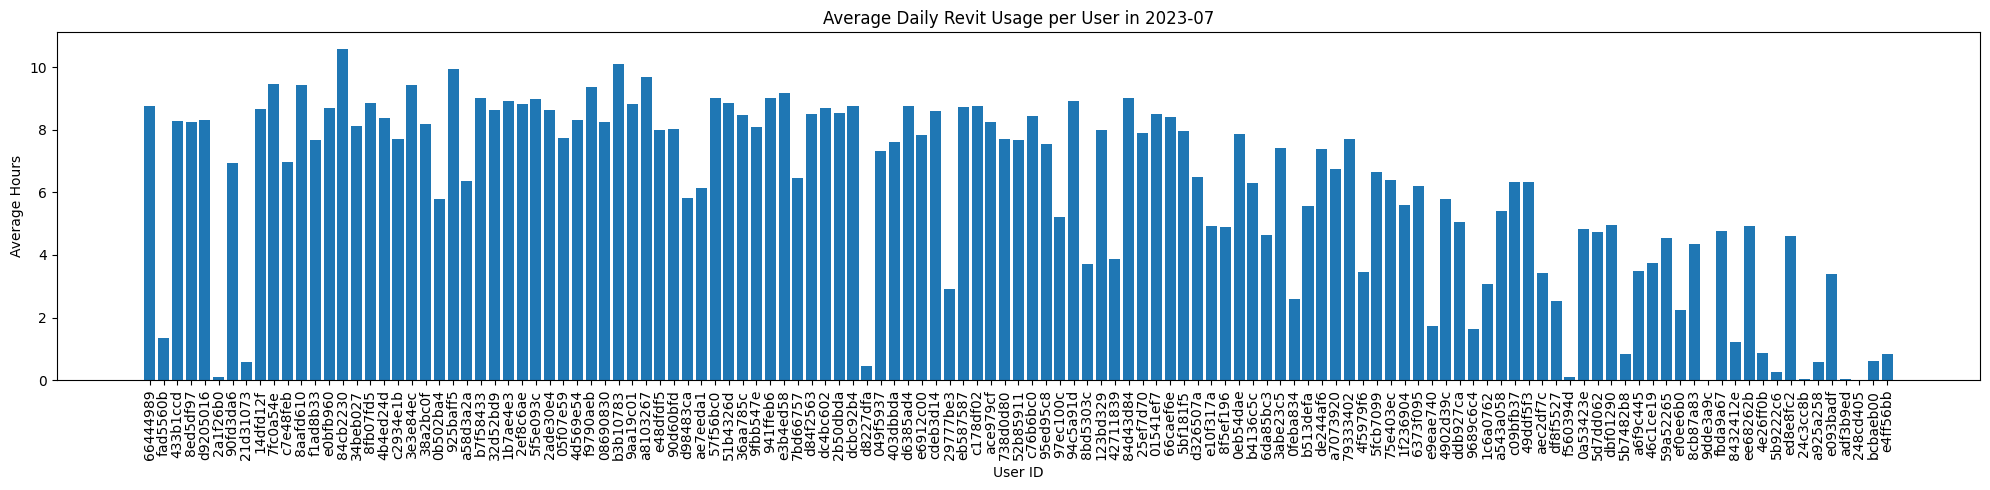

In [45]:
months = monthly_user_stats['month'].unique()
for m in months[:3]:

    df_plot = monthly_user_stats[monthly_user_stats['month'] == m].sort_values('time_in_hour')

    plt.figure(figsize=(20, 5))
    plt.scatter(df_plot['id'], df_plot['time_in_hour'], color='g', label='Avg. time_in')
    plt.scatter(df_plot['id'], df_plot['time_out_hour'], color='b', label='Avg. time_out')
    plt.title(f'Average Time In and Out per User in {m}')
    plt.xlabel('User ID')
    plt.ylabel('Hour of Day')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 5))
    plt.bar(df_plot['id'], df_plot['d_hours'])
    plt.title(f'Average Daily Revit Usage per User in {m}')
    plt.xlabel('User ID')
    plt.ylabel('Average Hours')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


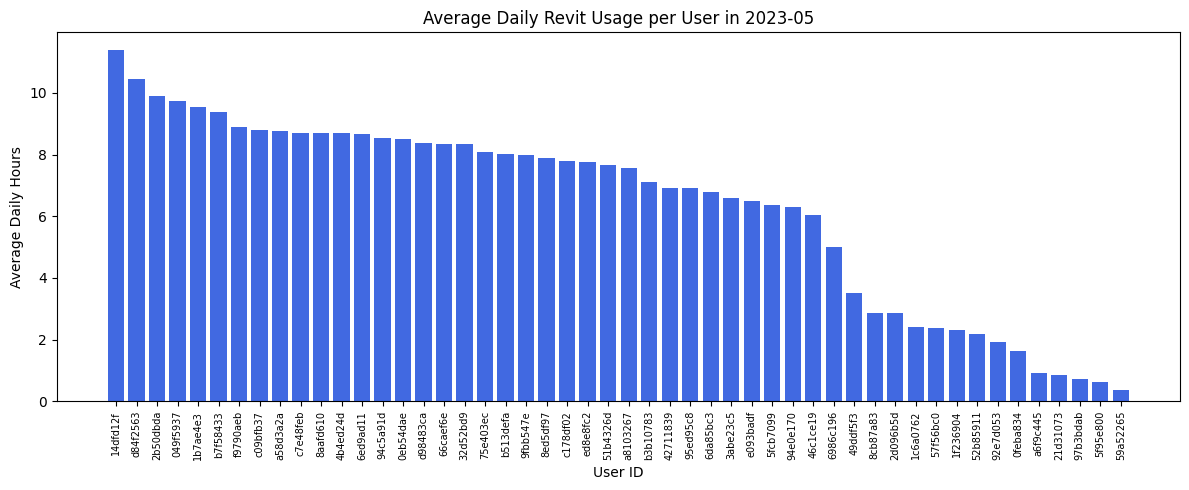

In [ ]:
import matplotlib.pyplot as plt

months = monthly_user_stats['month'].unique()
sample_n = 50

for m in months[:1]:
    df_plot = monthly_user_stats[monthly_user_stats['month'] == m]
    df_plot = df_plot.sample(n=min(sample_n, len(df_plot)), random_state=42)
    df_plot = df_plot.sort_values('avg_daily_hours', ascending=False)

    plt.figure(figsize=(12, 5))
    plt.bar(df_plot['id'], df_plot['avg_daily_hours'], color='royalblue')
    plt.title(f'Average Daily Revit Usage per User in {m}')
    plt.xlabel('User ID')
    plt.ylabel('Average Daily Hours')
    plt.xticks(rotation=90, fontsize=7)
    plt.tight_layout()
    plt.show()


In [46]:
# Add number of days active in the month
monthly_user_stats = all_days_df.groupby(['month', 'id']).agg(
    total_hours = ('d_hours', 'sum'),
    avg_daily_hours = ('d_hours', 'mean'),
    active_days = ('date', 'nunique')
).reset_index()

In [47]:
user_month_pivot = monthly_user_stats.pivot(index='id', columns='month', values='total_hours').fillna(0)

In [48]:
user_month_pivot['total_hours'] = user_month_pivot.sum(axis=1)
user_month_pivot['mean_monthly_hours'] = user_month_pivot.iloc[:, :-1].mean(axis=1)
user_month_pivot['months_active'] = (user_month_pivot.iloc[:, :-2] > 0).sum(axis=1)
user_month_pivot['months_>20h'] = (user_month_pivot.iloc[:, :-3] > 20).sum(axis=1)

In [49]:
def license_recommendation(row):
    if row['mean_monthly_hours'] > 20 and row['months_active'] > 6:
        return 'Dedicated'
    elif row['mean_monthly_hours'] > 5:
        return 'Shared'
    else:
        return 'Rare'

user_month_pivot['license_need'] = user_month_pivot.apply(license_recommendation, axis=1)

Thresholds choice:

- 20 hours/month ≈ 1 hour every working day: Suggests frequent, almost daily use.

- 6 months active: User needs Revit at least half the year, indicating a “permanent” need.

- 5 hours/month ≈ one short session per week: Below this, Revit is clearly not a main tool for the user.

Numbers could be adjusted.

In [50]:
user_month_pivot.head()

month,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,total_hours,mean_monthly_hours,months_active,months_>20h,license_need
id,,,,,,,,,,,,,,,
01541ef7,0.000000,30.183333,144.550000,47.516667,17.433333,16.600000,0.183333,0.000000,0.00,0.000000,256.466667,25.646667,6,3,Shared
049f5937,19.500000,142.400000,124.766667,90.000000,70.033333,2.566667,57.283333,134.050000,138.95,128.066667,907.616667,90.761667,10,8,Dedicated
05438ec8,0.000000,12.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,12.666667,1.266667,1,0,Rare
05f07e59,53.783333,181.650000,38.683333,143.116667,177.600000,198.133333,164.000000,98.766667,153.35,64.433333,1273.516667,127.351667,10,10,Dedicated
0631c7d8,0.000000,0.000000,0.000000,0.000000,0.000000,0.766667,0.000000,0.000000,0.00,0.000000,0.766667,0.076667,1,0,Rare


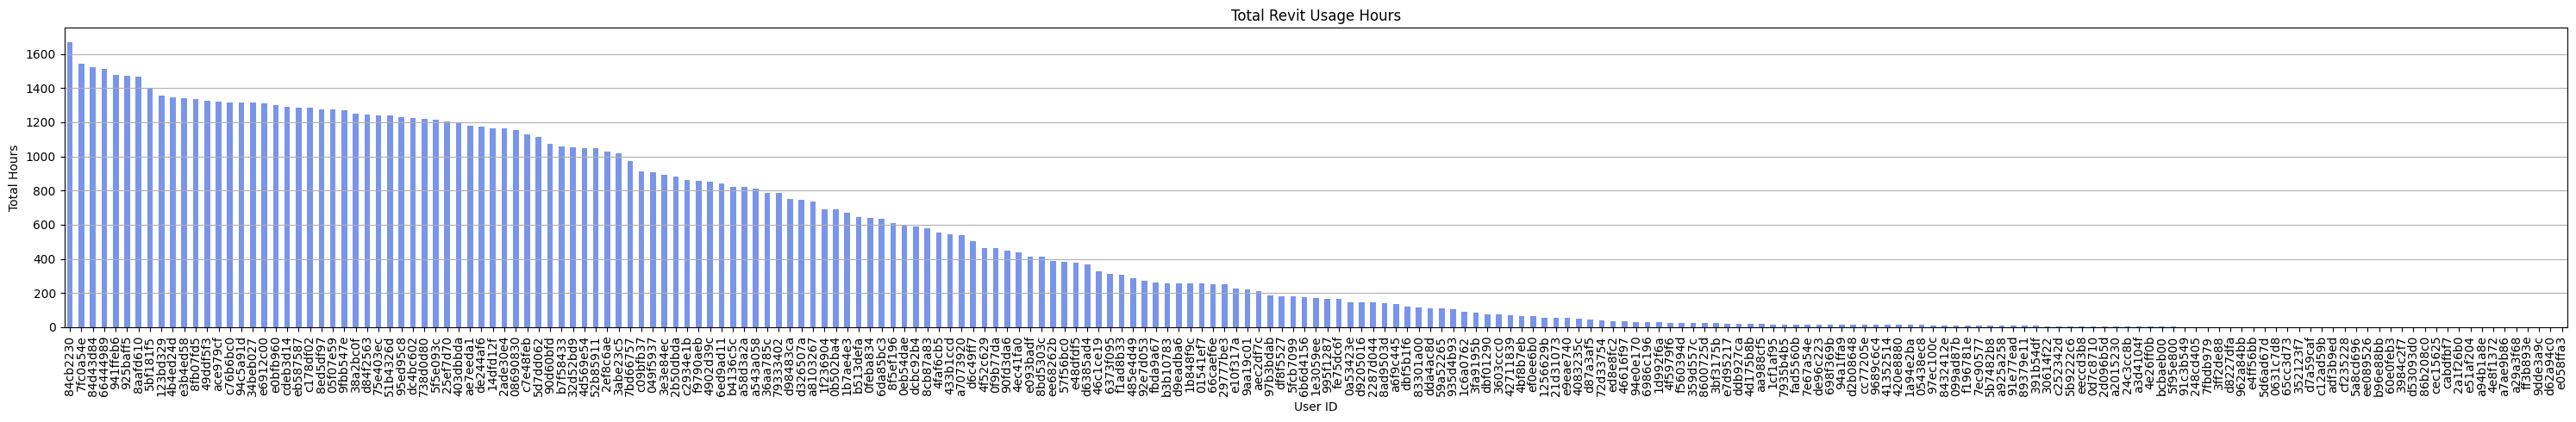

In [61]:
user_month_pivot.sort_values('total_hours', ascending=False)['total_hours'].plot(
    kind='bar', figsize=(30, 5), color='royalblue', alpha=0.7
)
plt.title('Total Revit Usage Hours')
plt.xlabel('User ID')
plt.ylabel('Total Hours')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


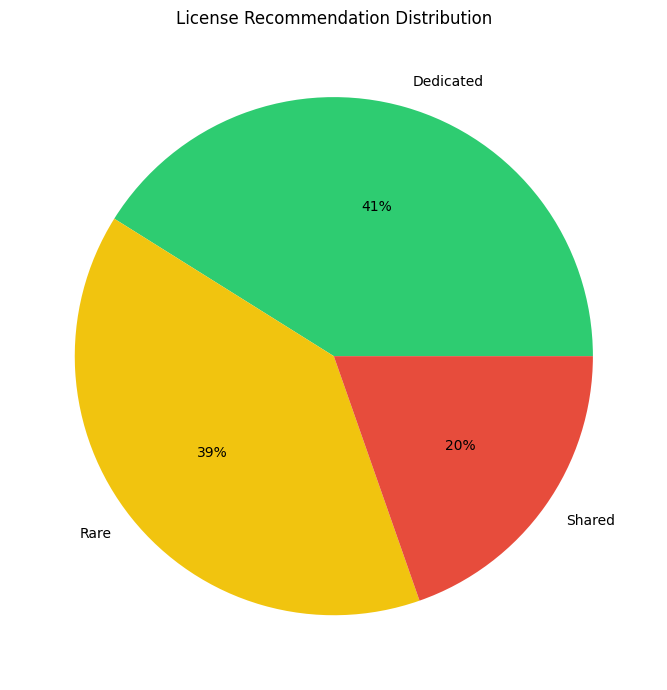

In [70]:
if 'license_need' in user_month_pivot.columns:
    user_month_pivot['license_need'].value_counts().plot(
        kind='pie', autopct='%1.0f%%', figsize=(7, 7), colors=['#2ecc71','#f1c40f','#e74c3c'])
    plt.title('License Recommendation Distribution')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

- **Dedicated:** Users who consistently use Revit a lot—average more than 20 hours per month, in more than 6 different months.
Why? These are your “core” users, likely working in Revit as part of their regular job. They need uninterrupted, reliable access—a dedicated license ensures they’re never blocked.

- **Shared:** Users with average monthly use above 5 hours but not as constant as Dedicated users.
Why? They use Revit regularly but less intensively, or only in certain periods. They can efficiently share floating licenses or be in a license pool.

- **Rare:** Users who use Revit on average 5 hours per month or less.
Why? They rarely need access, perhaps for occasional review or small tasks. These users can share licenses or use temporary access.

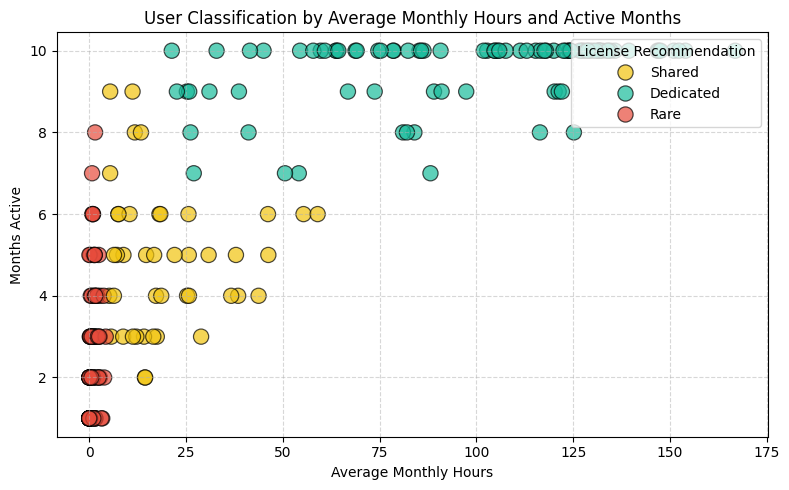

In [72]:
palette = {'Dedicated': '#1abc9c', 'Shared': '#f1c40f', 'Rare': '#e74c3c'}

plt.figure(figsize=(8, 5))

scatter = sns.scatterplot(
    data=user_month_pivot,
    x='mean_monthly_hours',
    y='months_active',
    hue='license_need',
    palette=palette,
    s=120,
    alpha=0.7,
    edgecolor='black'
)

plt.title('User Classification by Average Monthly Hours and Active Months')
plt.xlabel('Average Monthly Hours')
plt.ylabel('Months Active')
plt.legend(title='License Recommendation', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Saving the report

In [53]:
user_month_pivot.to_excel('./data/report/license_decision_report.xlsx')

### Business impact

In [54]:
license_counts = user_month_pivot['license_need'].value_counts()
n_dedicated = license_counts.get('Dedicated', 0)
n_shared = license_counts.get('Shared', 0)
n_rare = license_counts.get('Rare', 0)

In [55]:
shared_pool_factor = 0.5  # Can be adjusted
total_needed = n_dedicated + int(n_shared * shared_pool_factor)

In [56]:
license_price = 3303  # EUR per year for 2023
optimized_cost = total_needed * license_price

In [57]:
total_users = n_dedicated + n_shared + n_rare
current_cost = total_users * license_price
savings = current_cost - optimized_cost

In [58]:
print(f"Dedicated users (need full-time license): {n_dedicated}")
print(f"Shared users (can share floating licenses): {n_shared}")
print(f"Rare users (occasional, can use guest/rotation): {n_rare}")
print(f"\nRecommended licenses to purchase: {total_needed}")
print(f"Optimized annual licensing cost: €{optimized_cost:,.2f}")
print(f"Current annual licensing cost (old way): €{current_cost:,.2f}")
print(f"\nEstimated annual savings: €{savings:,.2f}")

Dedicated users (need full-time license): 90
Shared users (can share floating licenses): 43
Rare users (occasional, can use guest/rotation): 86

Recommended licenses to purchase: 111
Optimized annual licensing cost: €366,633.00
Current annual licensing cost (old way): €723,357.00

Estimated annual savings: €356,724.00


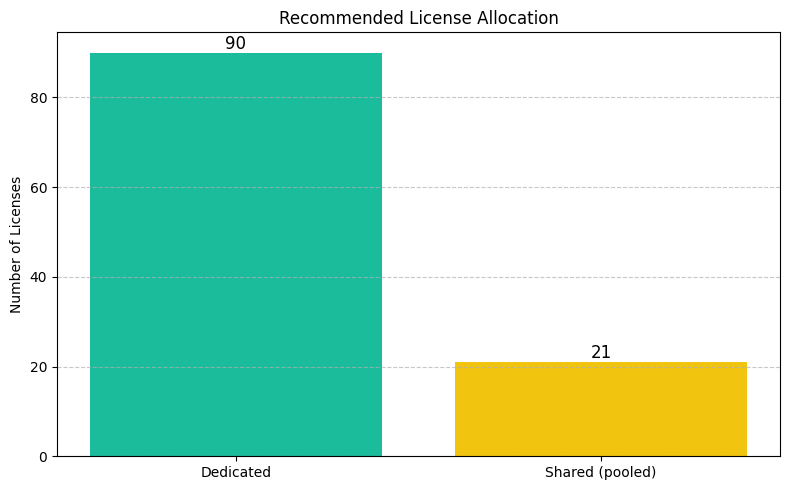

In [67]:
dedicated = n_dedicated
shared_equiv = int(n_shared * shared_pool_factor)

categories = ['Dedicated', 'Shared (pooled)']
values = [dedicated, shared_equiv]
colors = ['#1abc9c', '#f1c40f']

plt.figure(figsize=(8, 5))
bars = plt.bar(categories, values, color=colors)
plt.title('Recommended License Allocation')
plt.ylabel('Number of Licenses')
plt.bar_label(bars, fmt='%d', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

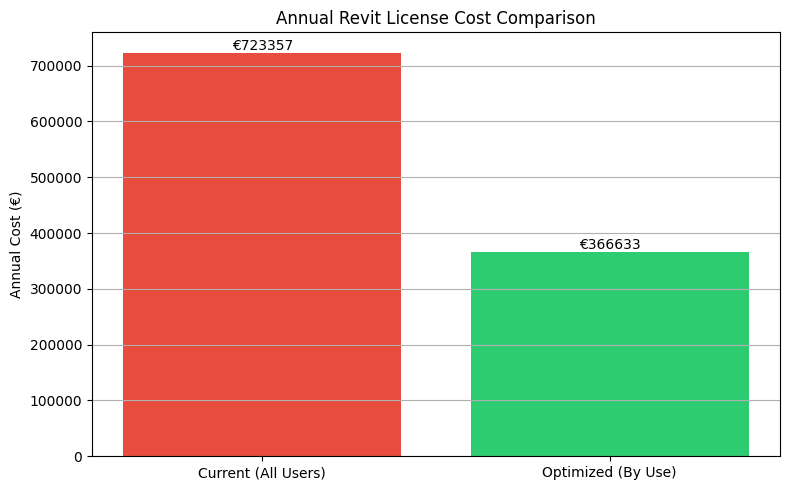

In [ ]:
methods = ['Current (All Users)', 'Optimized (By Use)']
costs = [current_cost, optimized_cost]
colors = ['#e74c3c', '#2ecc71']

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, costs, color=colors)
plt.title('Annual Revit License Cost Comparison')
plt.ylabel('Annual Cost (€)')
plt.bar_label(bars, fmt='€%d')
plt.grid(axis='y')
plt.tight_layout()
plt.show()